# Interpretive deep learning for identifying flooding mechanisms (EU)

This simple example will demonstrate how to apply the expected gradients and additive decomposition methods to interpret the LSTM-based hydrological model, as used in the paper

> Jiang, S., Bevacqua, E., & Zscheischler, J. (2022). **River flooding mechanisms and their changes in Europe revealed by explainable machine learning**, *Hydrology and Earth System Sciences*, 26, 6339–6359, https://doi.org/10.5194/hess-26-6339-2022

The main procedure includes data preparation, model training, predictive performance evaluation, and applying the interpretation methods to analyze the trained model.

For running this notebook, no GPU is required, and everything should run fine on a standard CPU. However, we recomend to use GPU for speeding up in practice.

Date: 22.03.2023

Created by: Shijie Jiang (shijie.jiang(at)hotmail.com)

In [1]:
import warnings, logging
warnings.simplefilter(action='ignore', category=FutureWarning)
logging.getLogger('matplotlib.font_manager').disabled = True

In [2]:
## Import libraries developed in this study
import libs.hydrodeepx_data as xdata
import libs.hydrodeepx_utils as xutils
import libs.hydrodeepx_interpret as xinterpret
import libs.hydrodeepx_plot as xplot

## Import dependent libraries
import os, logging, pickle, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras.backend as K
from keras import layers, models, callbacks, optimizers, regularizers
from tqdm.keras import TqdmCallback
from tqdm import tqdm
import tensorflow as tf
import innvestigate

plt.rcParams.update(plt.rcParamsDefault)

## Ignore all the warnings
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['KMP_WARNINGS'] = '0'

## Set seed for reproducible results
np.random.seed(42)
tf.set_random_seed(42)

Using TensorFlow backend.


In [3]:
####################
#  Hyperparameters #
####################
WORKING_PATH  = os.getcwd()
WRAP_LENGTH   = 180        # Timestep of the LSTM model
RANDOM_SEED   = 42
LEARNING_RATE = 0.01
EPOCH_NUMBER  = 50         # In the paper, we use 200 instead
FOLD_K        = 10         # We use 10-fold cross validation

## 1. Prepare data

First, we load the sample dataset for a station in Europe, which contains
- daily mean temperature (`tg`)
- daily precipitation (`rr`) 
- daily day length (`dl`)
- daily discharge (`fl`)

In [4]:
data_path = os.path.join(WORKING_PATH, 'data', 'sample_data.dly')
hydrodata = xdata.get_station_data_eu(fname=data_path, lat=50.54)
hydrodata

,tg,rr,dl,fl
1950-01-01,-1.919718,0.000000,7.841909,4.20
1950-01-02,-3.716641,1.024242,7.858506,4.20
1950-01-03,1.173102,3.878595,7.876582,4.79
1950-01-04,4.946878,2.965338,7.896120,6.97
1950-01-05,4.709783,1.042436,7.917100,6.97
...,...,...,...,...
2020-12-27,2.409867,8.361723,7.790593,NaN
2020-12-28,3.152777,10.376061,7.801134,NaN
2020-12-29,3.439627,1.856313,7.813209,NaN
2020-12-30,1.920741,2.165335,7.826805,NaN


### Plot the data loaded for overview

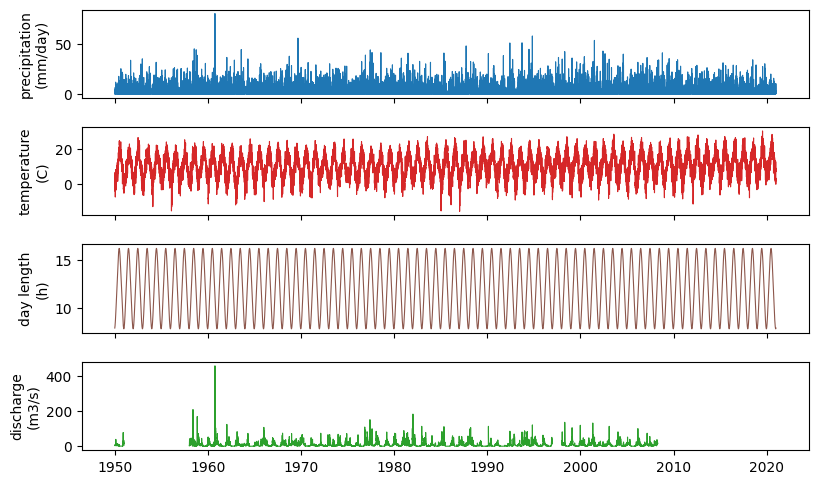

In [5]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(8, 5), dpi=100)
fig.tight_layout()

ax1.plot(hydrodata['rr'], 'tab:blue', lw=0.8)
ax2.plot(hydrodata['tg'], 'tab:red',  lw=0.8)
ax3.plot(hydrodata['dl'], 'tab:brown', lw=0.8)
ax4.plot(hydrodata['fl'], 'tab:green', lw=0.8)

ax1.set_ylabel("precipitation\n(mm/day)")
ax2.set_ylabel("temperature\n(C)")
ax3.set_ylabel("day length\n(h)")
ax4.set_ylabel("discharge\n(m3/s)")

plt.show()

### Gerenate data pairs (x and y) for the given `WRAP_LENGTH`

In [6]:
data_x_dict, data_y_dict = xdata.get_wrapped_data_eu(dataset=hydrodata, wrap_length=WRAP_LENGTH)

## 2. Define flood peaks as annual maximum discharges

Only flood peak events in the target list will be considered (`valid_peak_dates`).

In [7]:
peak_dates = xutils.identify_AM_peaks(Q = hydrodata['fl'])
valid_peak_dates = [peak_date for peak_date in peak_dates if peak_date in list(data_y_dict.keys())]

###############################################################################################
peak_x_dict = dict((peak_date, data_x_dict[peak_date]) for peak_date in valid_peak_dates if peak_date in data_x_dict)
peak_y_dict = dict((peak_date, data_y_dict[peak_date]) for peak_date in valid_peak_dates if peak_date in data_y_dict)

A total of 50 AM flood peaks are identified.


## 3. Model building and evaluation

### Split data samples for training and testing


In [8]:
split_results = xdata.split_train_test_eu(dataset=hydrodata, 
                                          data_x_dict=data_x_dict, 
                                          data_y_dict=data_y_dict, 
                                          k=FOLD_K, # we use 10-fold cross validation
                                          scale=True)

train_dates_list, test_dates_list, x_train_list, y_train_list, x_test_list, y_test_list, scale_params_list = split_results

print(f'The shape of x_train, y_train after wrapping by ' +
      f'{WRAP_LENGTH} days are {x_train_list[0].shape}, {y_train_list[0].shape}')

print(f'The shape of x_test, y_test after wrapping by ' +
      f'{WRAP_LENGTH} days are {x_test_list[0].shape}, {y_test_list[0].shape}')

The shape of x_train, y_train after wrapping by 180 days are (16345, 180, 3), (16345, 1)
The shape of x_test, y_test after wrapping by 180 days are (1817, 180, 3), (1817, 1)


### Define the model

In [9]:
def create_model(lstm_input_shape, summary=False):
    inputs = layers.Input(lstm_input_shape, name='input', dtype='float32')
    lstm   = layers.LSTM(units=32, name='lstm', return_sequences=False, 
                         kernel_regularizer=regularizers.l2(0.003), 
                         recurrent_regularizer=regularizers.l2(0.003))(inputs)
    output = layers.Dense(units=1, name='dense', activation='relu', use_bias=True, 
                          kernel_regularizer=regularizers.l2(0.003))(lstm)

    model  = models.Model(inputs, output)
    
    if summary:
        model.summary()
        
    return model

#####################################
# Some callbacks in fitting the model
es     = callbacks.EarlyStopping(monitor='val_R2', mode='max', verbose=0, patience=30, min_delta=0.01,
                                 restore_best_weights=True)
reduce = callbacks.ReduceLROnPlateau(monitor='val_R2', factor=0.5, patience=10, verbose=0, mode='max', 
                                     min_delta=0.01, cooldown=0, min_lr=LEARNING_RATE / 100)
tnan   = callbacks.TerminateOnNaN()
#####################################

# An overview of the model architecture, which will be used throughout the work
_ = create_model(lstm_input_shape=x_train_list[0].shape[1:], summary=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 180, 3)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                4608      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [10]:
model_list = []
pred_nse_list = []

for kk in range(FOLD_K)[:]:
    x_train      = x_train_list[kk]
    y_train      = y_train_list[kk]
    x_test       = x_test_list[kk]
    y_test       = y_test_list[kk]
    train_dates  = train_dates_list[kk]
    test_dates   = test_dates_list[kk]
    scale_params = scale_params_list[kk]
    ######################################
    # model fitting
    model = create_model(x_train.shape[1:])
    model.compile(loss=xutils.r_R2, # We use 1-R2 as the loss funcion 
                  metrics=[xutils.R2], 
                  optimizer=optimizers.Adam(lr=LEARNING_RATE))
    
    model.fit(x_train, y_train, epochs=EPOCH_NUMBER, batch_size=1024, validation_split=0.3,
              verbose=0, callbacks=[es, reduce, tnan,  TqdmCallback(verbose=1)])
    #######################################
    # model evaluation
    pred_train = model.predict(x_train, batch_size=10240)
    pred_test  = model.predict(x_test, batch_size=10240)
    
    pred_nse   = xutils.cal_nse(y_test, pred_test)
    
    hydrodata.loc[train_dates, [f'flow_pred_{kk}']] = pred_train * scale_params['train_y_b'] + scale_params['train_y_a']
    hydrodata.loc[test_dates,  [f'flow_pred_{kk}']] = pred_test  * scale_params['train_y_b'] + scale_params['train_y_a']
    
    print(f"fold {kk}: NSE for the testing data:  {pred_nse:.3f}")
    #######################################    
    model_list.append(model)
    pred_nse_list.append(pred_nse)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

fold 0: NSE for the testing data:  0.637


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

fold 1: NSE for the testing data:  0.840


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

fold 2: NSE for the testing data:  0.887


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

fold 3: NSE for the testing data:  0.906


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

fold 4: NSE for the testing data:  0.863


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

fold 5: NSE for the testing data:  0.879


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

fold 6: NSE for the testing data:  0.890


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

fold 7: NSE for the testing data:  0.892


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

fold 8: NSE for the testing data:  0.889


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

fold 9: NSE for the testing data:  0.860


In [11]:
print(f"The average NSE value in the {FOLD_K}-fold: {np.mean(pred_nse_list):03f}")

The average NSE value in the 10-fold: 0.854351


# 4. Interpret LSTM models by integrated gradients

In [12]:
def interpret_ig(model, peak_dict, scale_params, steps=800): 
    
    peak_x_data    = np.array(list(peak_dict.values()))
    peak_x_scaled  = (peak_x_data - scale_params['train_x_a'][None, None, :]) / scale_params['train_x_b'][None, None, :]

    analyzer       = innvestigate.create_analyzer("integrated_gradients", 
                                                  model, 
                                                  steps=steps,
                                                  reference_inputs=0 # Note we set 0 as our reference inputs
                                                  ) 

    peak_ig_values = analyzer.analyze(peak_x_scaled)
    peak_ig_values = np.expand_dims(peak_ig_values, 1)

    peak_ig_dict  = dict(zip(peak_dict.keys(), peak_ig_values))
    
    return peak_ig_dict

In [13]:
peak_ig_dict_list = []

for kk in tqdm(range(FOLD_K)[:]):
    peak_ig_dict = interpret_ig(model=model_list[kk], 
                                peak_dict=peak_x_dict, 
                                scale_params=scale_params_list[kk])
    peak_ig_dict_list.append(peak_ig_dict)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:02<00:00, 12.21s/it]


### Visualize the feature importance for peak discharge occured on 20 Feb. 1963

The recent precipitation ($\sum_{1}^{7}{\phi}^{P}_{i}$) in the case has a larger contribution to the peak compared to other factors)

Note: for each fold, we would get a set of feature importance for the identified peaks, here we only illustrate the feature importance derived in fold 0

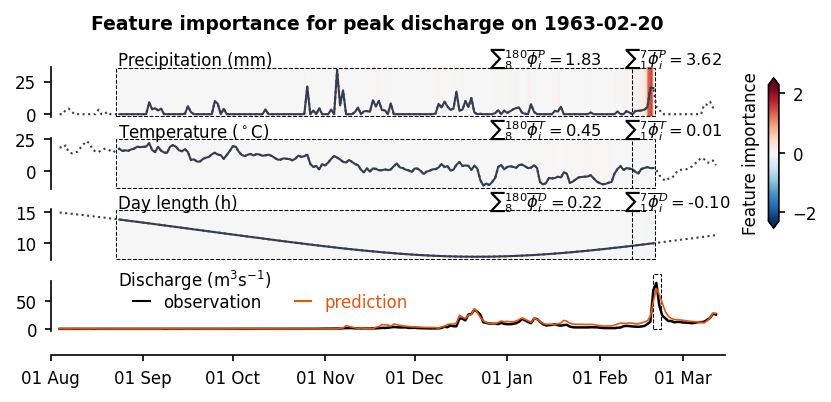

In [14]:
xplot.plot_importance(flood_date='1963-02-20', peak_ig_dict_list=peak_ig_dict_list, hydrodata=hydrodata, k=0)

### Visualize the feature importance for peak discharge occured on 26 Dec. 1995

The recent precipitation ($\sum_{8}^{180}{\phi}^{P}_{i}$) in the case has a larger contribution to the peak compared to other factors)

Note: for each fold, we would get a set of feature importance for the identified peaks, here we only illustrate the feature importance derived in fold 0

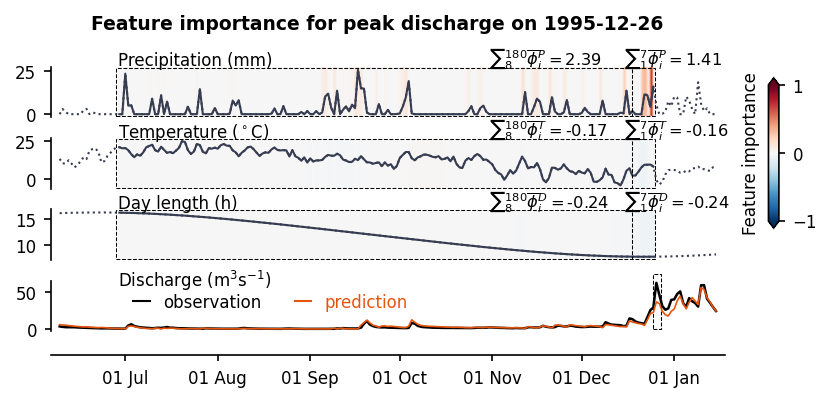

In [15]:
xplot.plot_importance(flood_date='1995-12-26', peak_ig_dict_list=peak_ig_dict_list, hydrodata=hydrodata, k=0)

# 5. Cluster analysis

- We can apply cluster analysis to the vector [$\sum_{1}^{7}{\phi}^{P}_{i}, \sum_{8}^{180}{\phi}^{P}_{i}, \sum_{1}^{7}{\phi}^{T}_{i}, \sum_{8}^{180}{\phi}^{T}_{i}, \sum_{1}^{7}{\phi}^{D}_{i}, \sum_{8}^{180}{\phi}^{D}_{i}$] of individual flood peaks pooled from all catchments (after scaling).


- In the main text, we used the feature importance averaged over the 10 folds (regardless of whether the sample was used for training or testing). Our supplemental analysis shows that using the feature importance of a sample when it was only used for testing will not change the conclusion.


- The cluster analysis is skipped here.